In [2]:
import numpy as np
from keras.layers import LSTM, Dense, TimeDistributed, BatchNormalization, Conv2D, Conv1D, Flatten, MaxPooling2D, Dropout, Bidirectional
from keras.models import Sequential, load_model
from keras import layers
from keras import callbacks
from keras import optimizers
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from transform_to_windows import transform_to_discrete_window_with_padding, transform_to_sliding_window, transform_labels
from load_and_scale import load_and_scale
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
random_state = 24
epochs = 1000
window_size = 30
start = 30
stride = 1
batch_size = 16
seek_forward = 1
lr = 0.0001
DATA_DIRECTORY = 'preprocessed'
filter_full_zero_rows = True
class_weight = {0: 0.5, 1: 2.0}
model_name = 'lstm_stride'+str(stride) + '_lr' + str(lr) + \
             '_batch_size' + str(batch_size) + '_' + str(class_weight.values()) + '_weights_start'+str(start) + \
             '_window'+str(window_size)+'_rowfilter_' + str(filter_full_zero_rows) + '.h5'
model_path = 'models/' + model_name

In [5]:
train_data, train_labels, test_data, test_labels = load_and_scale(DATA_DIRECTORY, 'periods.csv', 'gt.csv',
                                                                  split_percentage=0.8, should_filter=filter_full_zero_rows, random_state=random_state)

/root/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [6]:
train_data, validation_data, train_labels, validation_labels = train_test_split(train_data, train_labels, train_size=0.8, random_state=random_state)

/root/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [7]:
sliding_window_train = [transform_to_sliding_window(session, stride=stride, window_size=window_size, start=start) for session in train_data]

sliding_window_val = [transform_to_sliding_window(session, stride=stride, window_size=window_size, start=start) for session in validation_data]

sliding_window_test = [transform_to_sliding_window(session, stride=stride, window_size=window_size, start=start) for session in test_data]


In [8]:
sliding_window_train_labels = [transform_labels(labels, stride=stride, start=start, seek_forward=seek_forward) for labels in train_labels]

sliding_window_val_labels = [transform_labels(labels, stride=stride, start=start, seek_forward=seek_forward) for labels in validation_labels]

sliding_window_test_labels = [transform_labels(labels, stride=stride, start=start, seek_forward=seek_forward) for labels in test_labels]



In [9]:
# Should be extracted
def flatten_3d_arrays_to_2d(arrays):
    return [session.reshape(session.shape[0], session.shape[1] * session.shape[2]) for session in arrays]

In [10]:
concat_non_flat_train = np.concatenate(sliding_window_train)

concat_non_flat_val = np.concatenate(sliding_window_val)


concat_sliding_window_train_labels = np.concatenate(sliding_window_train_labels)
concat_sliding_window_val_labels = np.concatenate(sliding_window_val_labels)
concat_sliding_window_test_labels = np.concatenate(sliding_window_test_labels)

#### Drop the first ones

In [11]:
train_labels = [label[start:] for label in train_labels]
test_labels = [label[start:] for label in test_labels]

#### Flattened (2D) data for traditional models

In [12]:
flattened_train = flatten_3d_arrays_to_2d(sliding_window_train)
concatenated_train = np.concatenate(flattened_train)
concatenated_train_labels = np.concatenate(train_labels)
flattened_test = flatten_3d_arrays_to_2d(sliding_window_test)
concatenated_test = np.concatenate(flattened_test)
concatenated_test_labels = np.concatenate(test_labels)

### Logistic regression training

In [14]:
log_reg = LogisticRegression()
log_reg.fit(concatenated_train, concat_sliding_window_train_labels)
log_reg_predictions = log_reg.predict(concatenated_test)

print(confusion_matrix(concat_sliding_window_test_labels, log_reg_predictions))
print(accuracy_score(concat_sliding_window_test_labels, log_reg_predictions))
print(recall_score(concat_sliding_window_test_labels, log_reg_predictions))
print(precision_score(concat_sliding_window_test_labels, log_reg_predictions))
print(f1_score(concat_sliding_window_test_labels, log_reg_predictions))

[[1562   14]
 [ 174   35]]
0.8946778711484594
0.1674641148325359
0.7142857142857143
0.2713178294573644


### Random Forest training

In [15]:
rf = RandomForestClassifier()

rf.fit(concatenated_train, concat_sliding_window_train_labels)
rf_predictions = rf.predict(concatenated_test)
print(confusion_matrix(concat_sliding_window_test_labels, rf_predictions))
print(accuracy_score(concat_sliding_window_test_labels, rf_predictions))
print(recall_score(concat_sliding_window_test_labels, rf_predictions))
print(precision_score(concat_sliding_window_test_labels, rf_predictions))
print(f1_score(concat_sliding_window_test_labels, rf_predictions))

[[1560   16]
 [ 110   99]]
0.9294117647058824
0.47368421052631576
0.8608695652173913
0.611111111111111


### LSTM Training

In [16]:
model = Sequential()
model.add(layers.LSTM(64, input_shape=(sliding_window_train[0].shape[1], sliding_window_train[0].shape[2]), dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=lr), metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                20992     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 21,057
Trainable params: 21,057
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
history = model.fit(concat_non_flat_train, concat_sliding_window_train_labels,
                        validation_data=(concat_non_flat_val, concat_sliding_window_val_labels),
                        epochs=epochs,
                        batch_size=batch_size, shuffle=False, verbose=2,
                        callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=20),
                                   callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, period=1)],
                        class_weight=class_weight)

Train on 5570 samples, validate on 1612 samples
Epoch 1/1000
 - 8s - loss: 0.4966 - acc: 0.8436 - val_loss: 0.6419 - val_acc: 0.8220
Epoch 2/1000
 - 8s - loss: 0.4915 - acc: 0.8546 - val_loss: 0.5893 - val_acc: 0.8220
Epoch 3/1000
 - 7s - loss: 0.4837 - acc: 0.8348 - val_loss: 0.5261 - val_acc: 0.8220
Epoch 4/1000
 - 7s - loss: 0.4658 - acc: 0.7977 - val_loss: 0.5046 - val_acc: 0.8158
Epoch 5/1000
 - 7s - loss: 0.4552 - acc: 0.7928 - val_loss: 0.4924 - val_acc: 0.7959
Epoch 6/1000
 - 7s - loss: 0.4476 - acc: 0.7840 - val_loss: 0.4853 - val_acc: 0.8002
Epoch 7/1000
 - 7s - loss: 0.4441 - acc: 0.7820 - val_loss: 0.4777 - val_acc: 0.8046
Epoch 8/1000
 - 7s - loss: 0.4393 - acc: 0.7858 - val_loss: 0.4786 - val_acc: 0.8127
Epoch 9/1000
 - 7s - loss: 0.4278 - acc: 0.7781 - val_loss: 0.4831 - val_acc: 0.8244
Epoch 10/1000
 - 6s - loss: 0.4300 - acc: 0.7776 - val_loss: 0.4698 - val_acc: 0.8189
Epoch 11/1000
 - 7s - loss: 0.4234 - acc: 0.7758 - val_loss: 0.4586 - val_acc: 0.8232
Epoch 12/1000
 

### Shouldn't look like this, but there isn't enough data

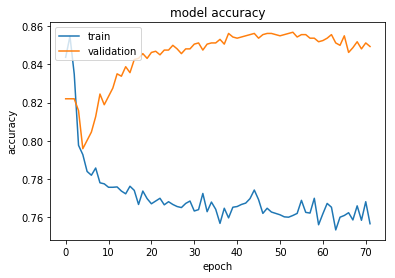

In [19]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Also seems like a case of overfitting

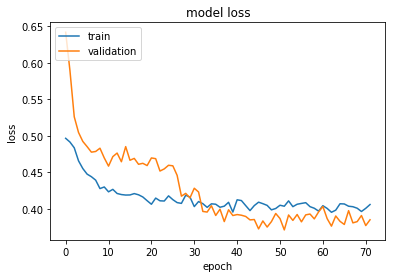

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [21]:
sliding_window_concat_test = np.concatenate(sliding_window_test)

In [22]:
predictions = model.predict_classes(sliding_window_concat_test, batch_size=1)

In [23]:
print(confusion_matrix(concat_sliding_window_test_labels, predictions))
print(accuracy_score(concat_sliding_window_test_labels, predictions))
print(recall_score(concat_sliding_window_test_labels, predictions))
print(precision_score(concat_sliding_window_test_labels, predictions))
print(f1_score(concat_sliding_window_test_labels, predictions))

[[1532   44]
 [  61  148]]
0.9411764705882353
0.7081339712918661
0.7708333333333334
0.7381546134663343
